# Automated diagnosis of skin lesions for detection of Skin Cancer

This Jupyter Notebook is created for the **Biotech Final Year Project** of **MNNIT Allahabad, Dept of Biotechnology**.

The notebook contains code to detect skin cancer by automatically classifying images of skin lesions into various diagnostic categories using Deep Learning techniques.

This notebook and all other relevant files are available on [GitHub](https://github.com/agg-geek/skincancer).

#### Project Supervisor:

-   Dr. Ashutosh Mani,  
    Associate Professor, Department of Biotechnology

#### Project team members:

-   Abhinav Aggarwal, 20200003  
    Final year B Tech, Biotechnology

## About the dataset

[HAM10000 dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)

**HAM10000** stands for “Human Against Machine with 10000 training images”.  
It’s a dataset with **10015** high quality, close-up dermatoscopic **images of skin lesions** aimed for training models for skin cancer detection.   
All the images have color, with height 450 pixels and width 600 pixels.

The images were collected from two different sites, the Department of Dermatology at the Medical University of Vienna, Austria, and the skin cancer practice of Cliff Rosendahl in Queensland, Australia. Over 20 years of skin lesion images from the two sites were extracted, cleaned, and reformatted to create HAM10000.

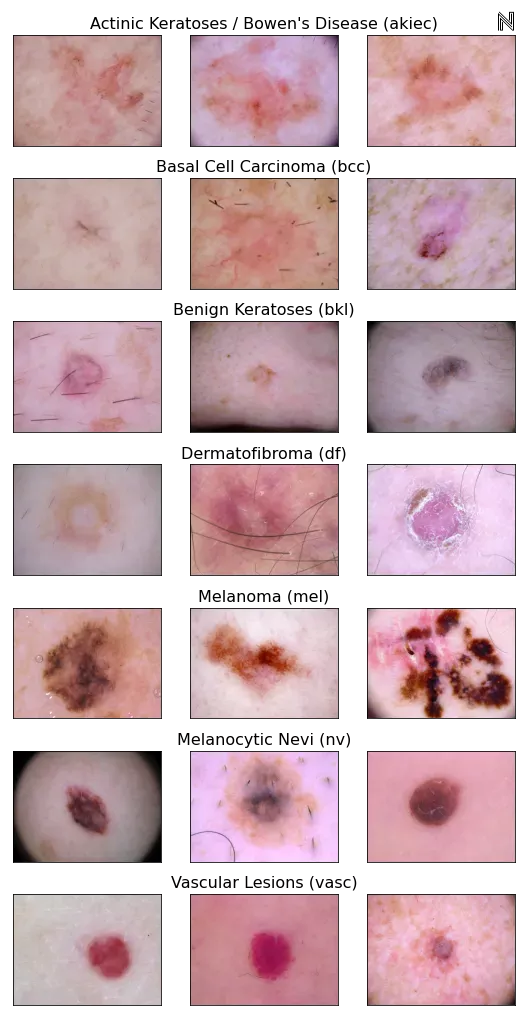

### Classes of skin lesions

- Actinic Keratoses / Bowen’s Disease (**akiec**)
- Basal Cell Carcinoma (**bcc**)
- Benign Keratoses (**bkl**)
- Dermatofibroma (**df**)
- Melanoma (**mel**)
- Melanocytic Nevi (**nv**)
- Vascular Lesions (**vasc**)

- Skin lesions of the following types are typically cancereous (**malignant**)
    - **Melanoma**
    - **Actinic Keratoses / Bowen’s Disease**
    - **Basal Cell Carcinoma**  
- Skin lesions of other types are typically **benign**.

### Verification of skin lesions

- Histopathology (`histo`): the original diagnosis was performed by specialized dermatopathologists and were manually reviewed for plausibility.
- Confocal (`confocal`): this refers to reflectance confocal microscopy, which is an in-vivo imaging technique with a resolution at near-cellular level, and it was used for verification
- Follow-up (`follow-up`): the researchers tracked the patient associated with the skin lesion through various follow-ups and over a period of time to ensure the benign diagnosis was truly benign (i.e., didn’t develop to an active cancer)
- Consensus (`consensus`): used a panel of experts where other verification techniques couldn’t be used

### Dataset labels

- `lesion_id`: patient associated with the skin lesion. It is of the form `HAM_X`, where `X` is a 7-digit unique identifier number (multiple skin lesions can come from the same patient)
- `image_id`: name of the image in the HAM10000 data folders. It is of the form `ISIC_X` where `X` is a 7-digit unique identifier number (each image has its own ISIC number), this will be useful for finding the image in the data directory
- `dx`: class of the skin lesion (diagnosis)
- `dx_type`: type of verification of diagnosis of skin lesion
- `age`: age of the patient associated with the skin lesion image
- `sex`: sex of the patient associated with the skin lesion image (will be male, female, or unknown)
- `localization`: location of the skin lesion on the body (e.g. back, hand, scalp, etc)

## Imports

### Import packages

In [2]:
import os
import numpy as np
import pandas as pd
from numpy.random import seed
seed(101)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns

import tensorflow
from tensorflow import set_random_seed
set_random_seed(101)
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from glob import glob
import itertools
import shutil

### Import dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('skin-cancer-mnist-ham10000.zip', 'r')
zip_ref.extractall('/content/raw')
zip_ref.close()

## Data Preprocessing

In [3]:
class_labels = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

In [4]:
lesion_desc = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
# df_data = pd.read_csv('/content/raw/HAM10000_metadata.csv')
# df_data.head()

df_data = pd.read_csv('../input/HAM10000_metadata.csv')
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Handle duplicate (augmented) images

In [6]:
# cnt of images associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# filter out lesion_id's having only one image associated with it
df = df[df['image_id'] == 1]
df.reset_index(inplace=True)

In [7]:
# Identify lesion_id's having duplicate images and those having only one image

def identify_duplicates(x):
    unique_list = list(df['lesion_id'])
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# apply the function to this new column)
df_data['duplicates'] = df_data['lesion_id'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [8]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [9]:
# Filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']
df.shape

(5514, 8)

## Exploratory Data Analysis

In [10]:
# df_eda = df.copy()
df_eda = pd.read_csv('../input/HAM10000_metadata.csv')
df_eda.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [11]:
df_eda['cell_type'] = df_eda['dx'].map(lesion_desc.get)
df_eda['cell_type_idx'] = pd.Categorical(df_eda['cell_type']).codes

df_eda.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2


### Data Cleaning

In [12]:
df_eda.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
cell_type         0
cell_type_idx     0
dtype: int64

In [13]:
# df_eda['age'].fillna((df_eda['age'].mean()), inplace=True)
df_eda['age'] = df_eda['age'].fillna(df_eda['age'].mean())

In [14]:
df_eda.isna().sum().sum()

0

### Univariate analysis

#### Diagnosis distribution

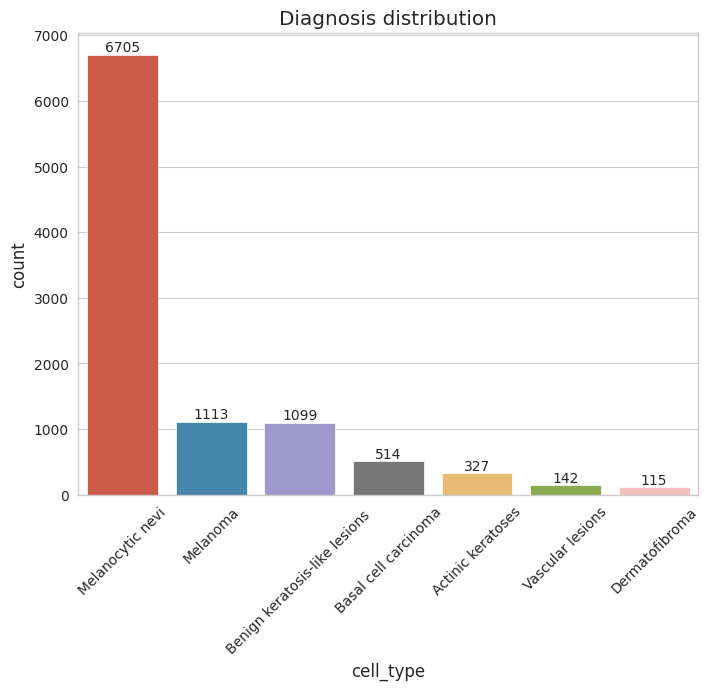

In [15]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8,6))
# ax = sns.countplot(x='cell_type',data=df_eda, order = df_eda['cell_type'].value_counts().index, palette = 'crest')
ax = sns.countplot(x='cell_type',data=df_eda, order = df_eda['cell_type'].value_counts().index)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Diagnosis distribution')
plt.xticks(rotation=45)
plt.show()

- The dataset is extremely unbalanced. 
- There are vast number of cases of Melanocytic nevi as compared to others. This `nv` category has 6705 images in the dataset, which means it has more representation than all the other categories combined. 
- Melanoma and Benign keratosis-like lesions are quite less wide spread as compared to Melanocytic nevi, which is important as Melanoma is cancerous.
- Model should be modified and evaluated while considering the skewness
- Other cell type viruses subsequently affected less in numbers.

#### Demographic / Patient Distributions

##### Distribution of age

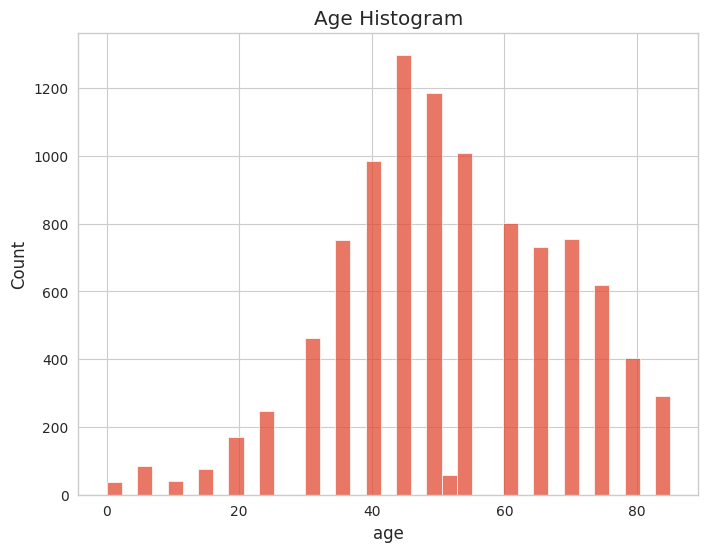

In [16]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8, 6))
ax = sns.histplot(data=df_eda, x='age')
plt.title('Age Histogram')
plt.show()

- The range of ages in the HAM10000 dataset is from 0 to 85 years. 
- The distribution appears to be bimodal, with a large number of patients in the 35–50 age range and 60–75 age range. 
- Most of the patients in the dataset are [generally older](https://www.cdc.gov/cancer/dcpc/research/articles/older-adults-protect-skin-sun.htm#:~:text=Most%20cases%20of%20skin%20cancer,is%20more%20critical%20than%20ever.). This distribution matches the general trend about skin cancer, in that it typically affects older individuals. 
- There doesn’t seem to be any anomalies in the ages.

##### Distribution of sex

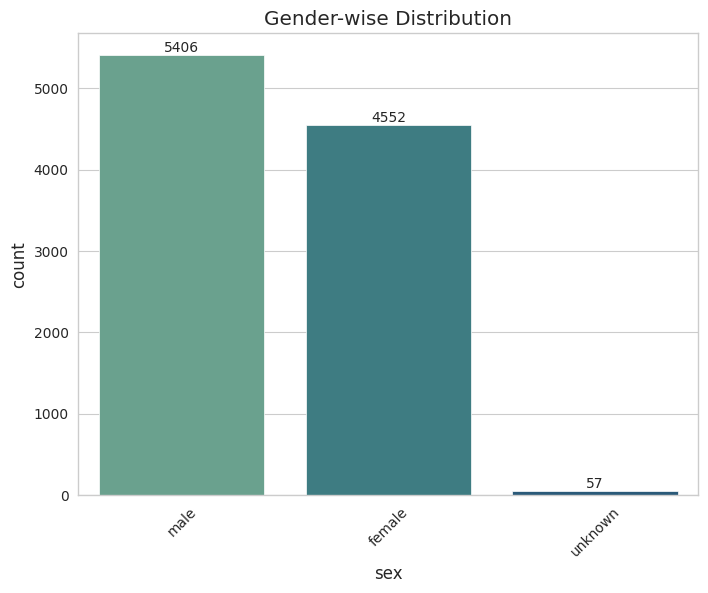

In [17]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8, 6))

ax = sns.countplot(x='sex',data=df_eda, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.show()

- We see that the `male` category has the most representation and there are roughly 1000 more images (10% more representation) for the `male` category than the `female` category. 
- Ideally, there should be an equal representation of both sexes, but since the imbalance is relatively small, it requires no investigation.
- There are 57 images with an `unknown` sex — these indicate images where the annotation on sex was not available. 
    - These can be discarded as the images will be used for transfer learning. 
    - However, a multimodal learning solution might need these images to be investigated.

##### Distribution of localization

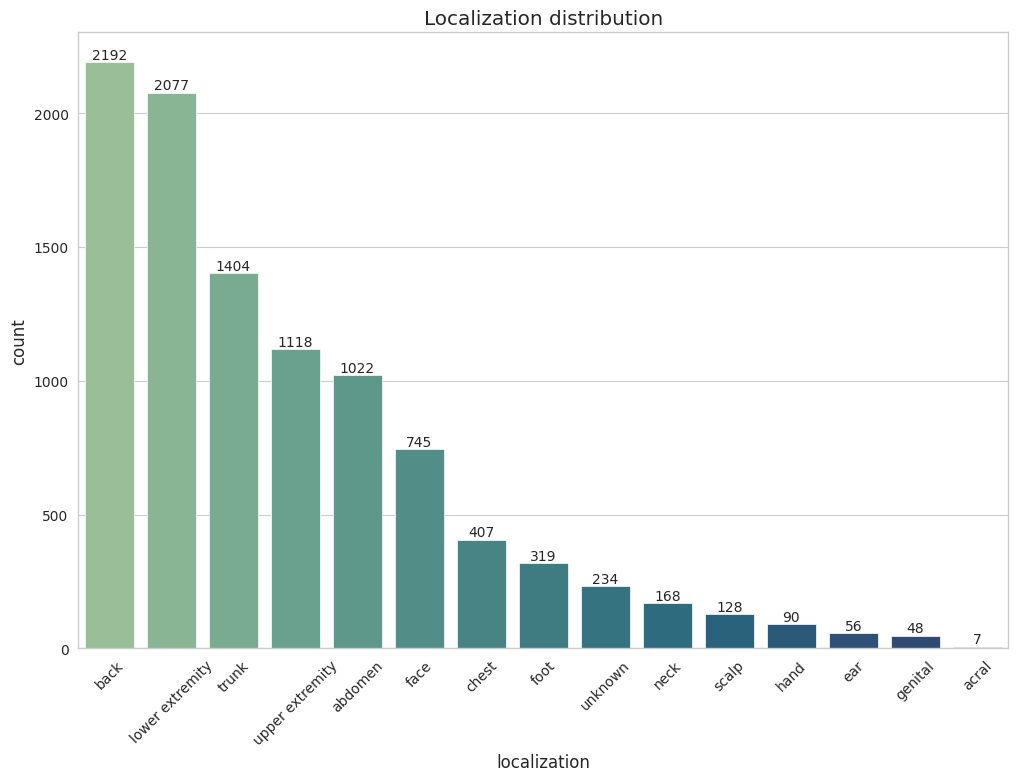

In [18]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=df_eda, order = df_eda['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization distribution')
plt.xticks(rotation=45)
plt.show()

- The localization of the skin lesion is very imbalanced.
- A large number of skin lesions are located on the back, lower extremity, and the trunk
- In contrast, the number of lesions in acral areas, genital, and ears combined barely cross 100 examples (~1% of the dataset). 
- Since skin lesions can look very different depending on the part of the body, this imbalance can ultimately affect model’s performance and its ability to predict correctly on skin lesions found in less represented locations in the body. 
- This can be a future area of improvement for developing better models.

#### Diagnosis verification types

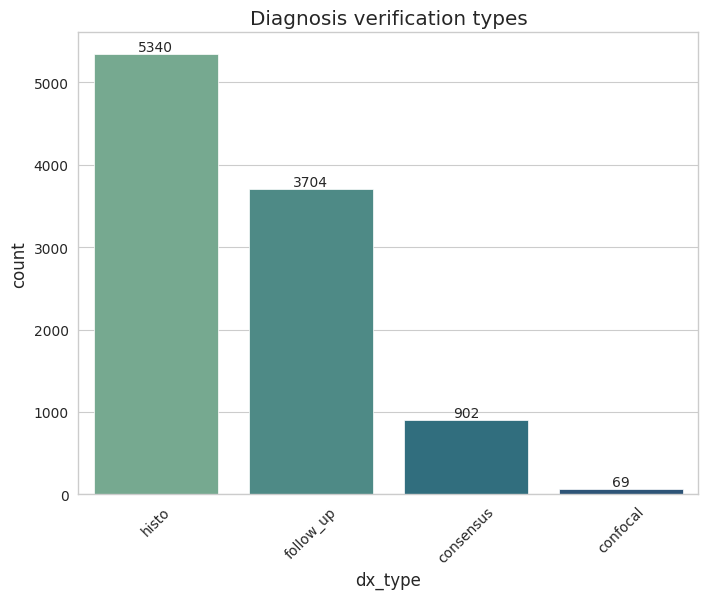

In [19]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='dx_type',data=df_eda, order = df_eda['dx_type'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Diagnosis verification types')
plt.xticks(rotation=45)
plt.show()

#### Comparison of frequencies for diagnosis and diagnosis-types

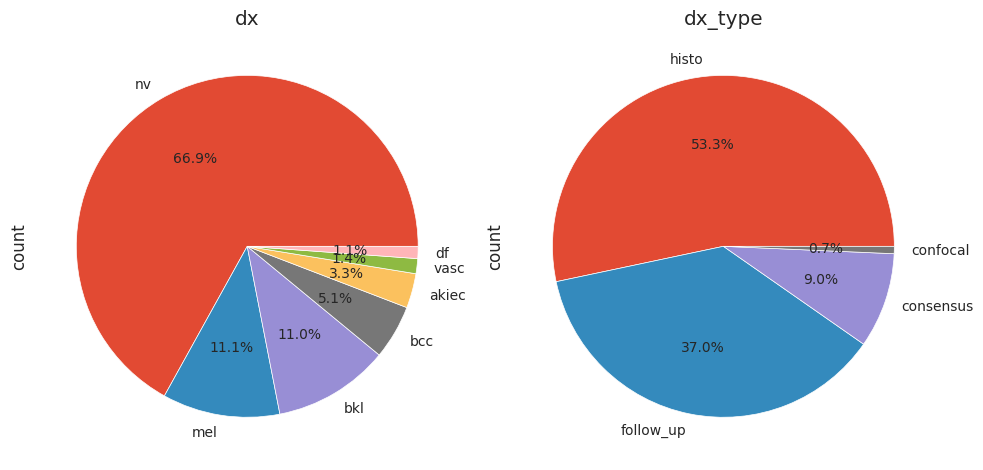

In [20]:
plt.figure(figsize=(10, 8))

# Plotting pie chart for 'dx'
plt.subplot(1, 2, 1)
df_eda['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.title('dx')

# Plotting pie chart for 'dx_type'
plt.subplot(1, 2, 2)
df_eda['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.title('dx_type')

plt.tight_layout()
plt.show()

### Bivariate analysis

#### Diagnosis vs Sex

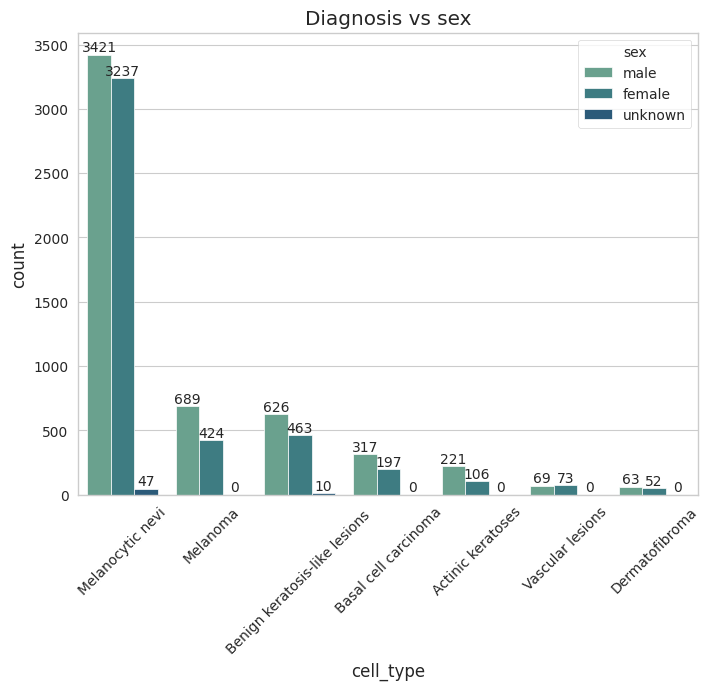

In [21]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8,6))
ax = sns.countplot(x='cell_type',hue='sex', data=df_eda, order = df_eda['cell_type'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Diagnosis vs sex')
plt.xticks(rotation=45)
plt.show()

- Some diagnoses `akiec`, `bcc`, `bkl` and `mel` have a greater difference between male and female which might indicate that these types of skin cancer is more prevalent in males than females. 
- This conclusion should be taken with a pinch of salt as this might be a reflection of distribution imbalance in the broader dataset due to the following possible biases:
  - There are more skin lesions in males than females, so naturally, there will be more male examples.
  - There isn't enough data of a certain diagnosis.
- There can be use of statistical tests like proportion tests to see if there’s significant differences in sex representation across the different diagnoses.

#### Age vs Diagnosis

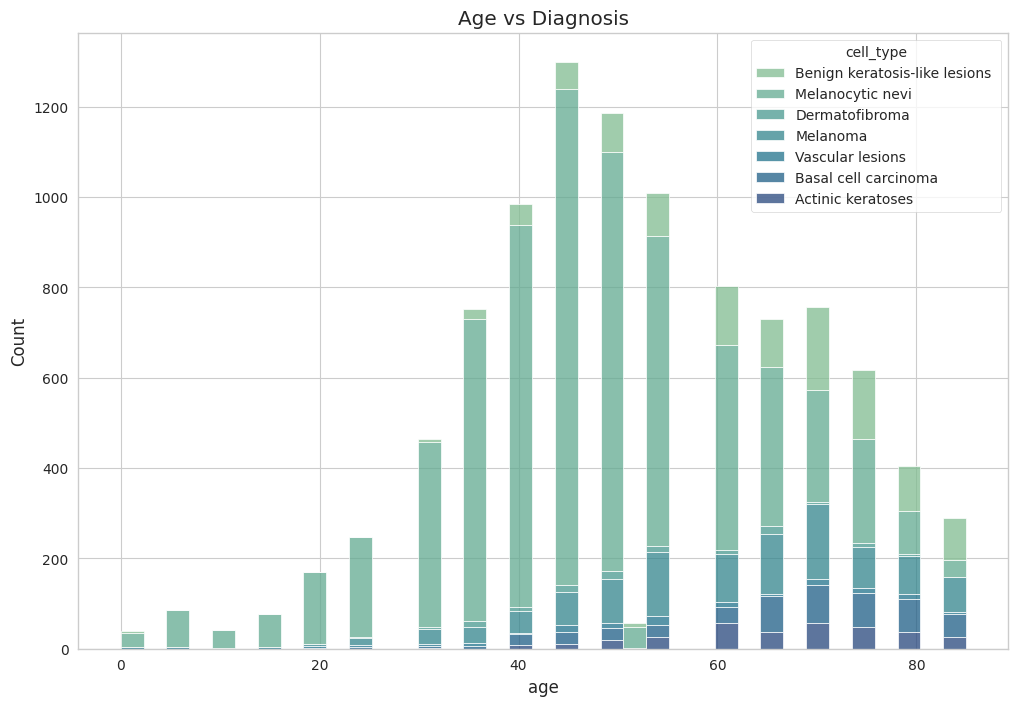

In [22]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df_eda, x='age',hue='cell_type',multiple='stack', palette = 'crest')
plt.title('Age vs Diagnosis')
plt.show()

- Some diagnoses only have people over a certain age, such as `akiec` where the youngest patients recorded was around 30 years old. 
- This is very different from `vasc` and `nv` which have very young patients. 
- This indicates that some cancer diagnoses are more likely to affect older patients. 
- Similar to age vs diagnosis, problems in data distribution and bias may be present. 
- For future investigation, statistical tests like ANOVA test can be used to check for significant differences in age across the different diagnoses.
<br> <br>
- `vasc` and `nv` are non-cancerous / benign diagnosis which occur in young patients. Thus, another conclusion could be that cancerous / malignant diagnosis could affect older ages. 
- This can be tested this by differentiating diagnoses into a non-cancerous and cancerous group and then using statistical tests like t-test for comparison and verification.

#### Localization by Diagnosis

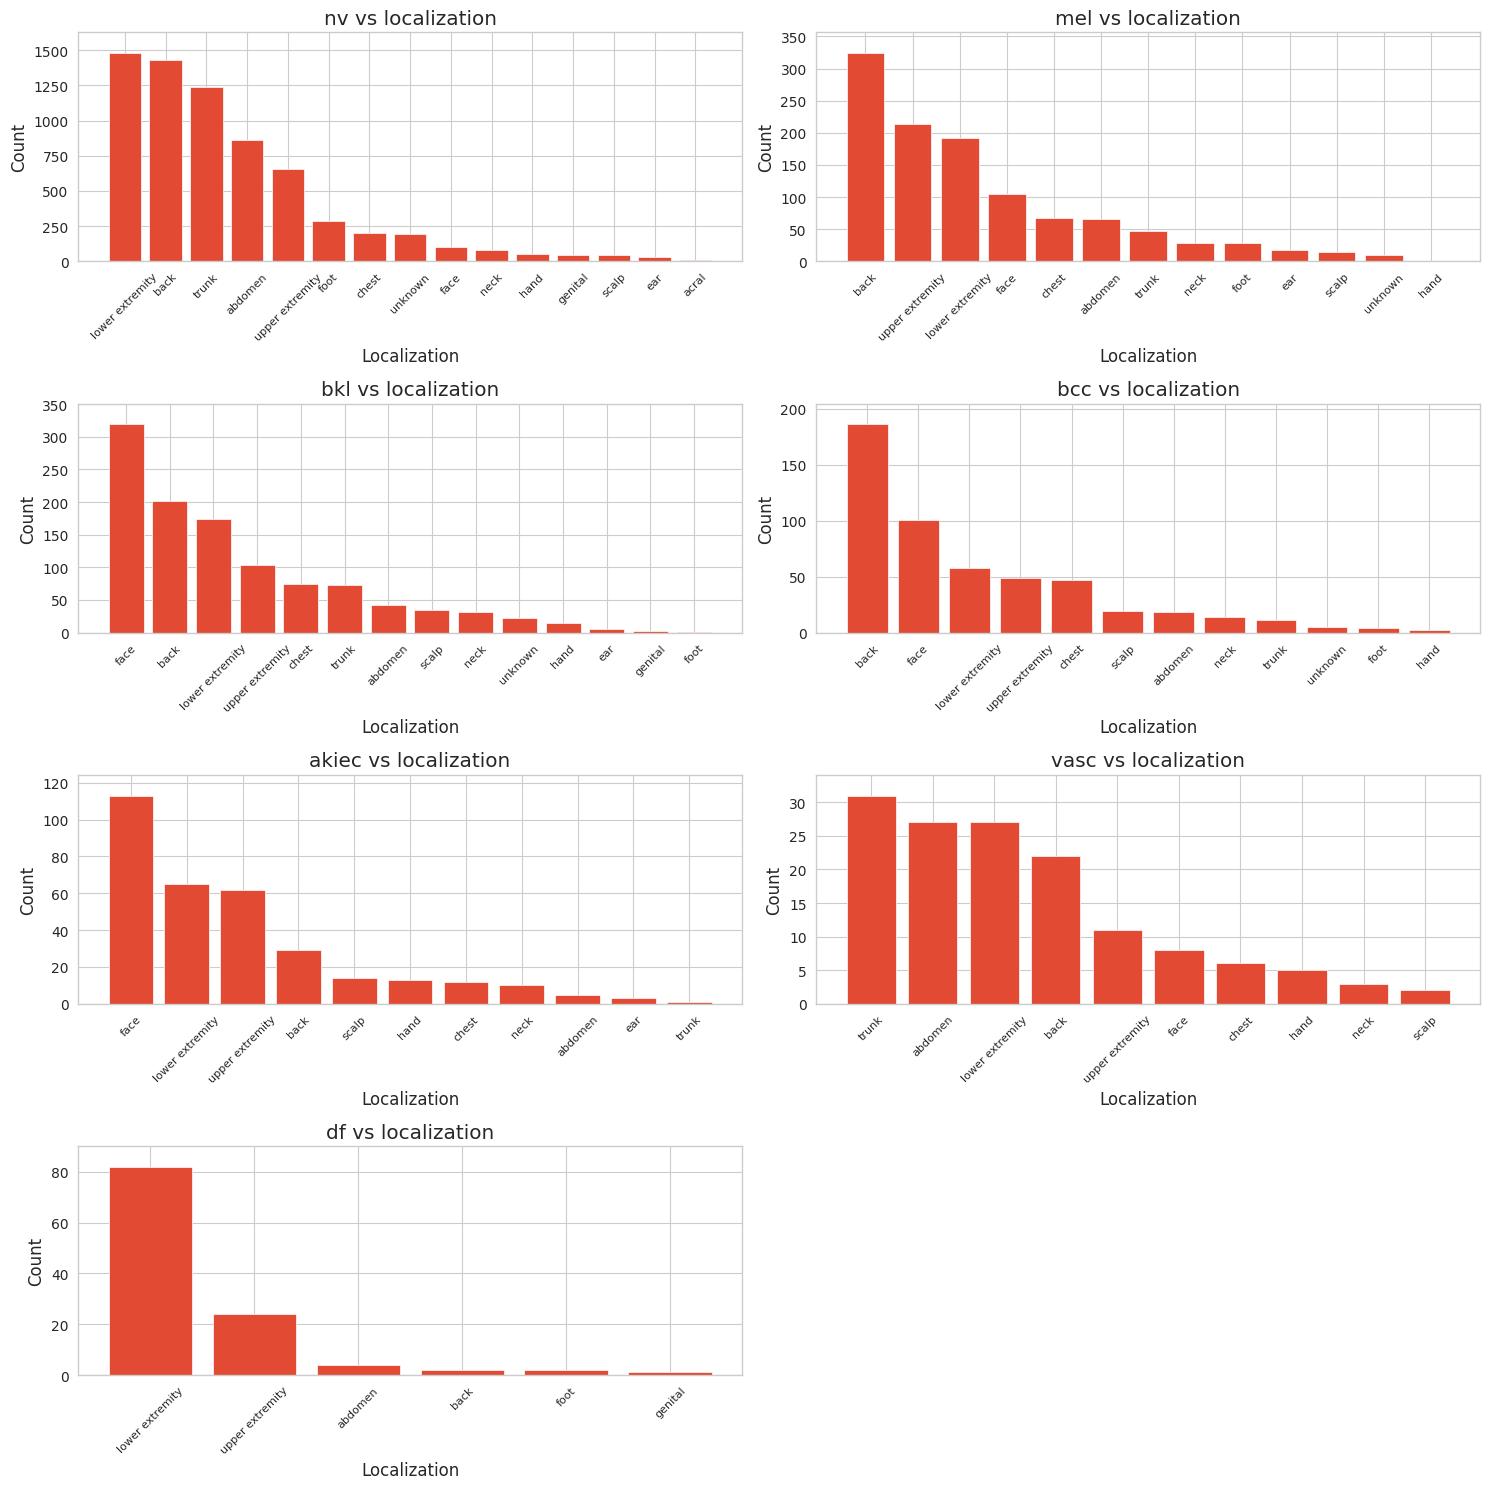

In [23]:
df2 = df_eda.groupby('dx')['localization'].value_counts().reset_index()

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
axes = axes.flatten()

# for i, (localization, count) in enumerate(zip(df['localization'], df['count'])):
for idx, lesion_class in enumerate(class_labels):
    df_temp = df2[df2['dx'] == lesion_class]
    df_temp = df_temp.drop(columns=['dx'], axis=1)
    
    ax = axes[idx]  # Select the current subplot
    ax.bar(df_temp['localization'], df_temp['count'])
    ax.set_title(f"{lesion_class} vs localization")
    ax.set_xlabel('Localization')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45, labelsize=8)  # Rotate x-axis labels for better visibility
    # ax.text(0.5, 0.5, df['count'], ha='center', va='center', fontsize=8)  # Display count value in the middle of the bar
    ax.set_ylim(0, max(df_temp['count']) * 1.1)  # Set y-axis limit to 10% higher than the maximum count

# Hide empty subplots
for i in range(7, 8):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

- `df` seems to exclusively happen on the lower and upper extremity
- The back is home to many of the diagnoses, except for `df` and `akiec`, both of which have a relatively smaller percentage of examples located there
- The face seems to be the most prevalent location for `akiec` and `bkl`

#### Sex vs Localization

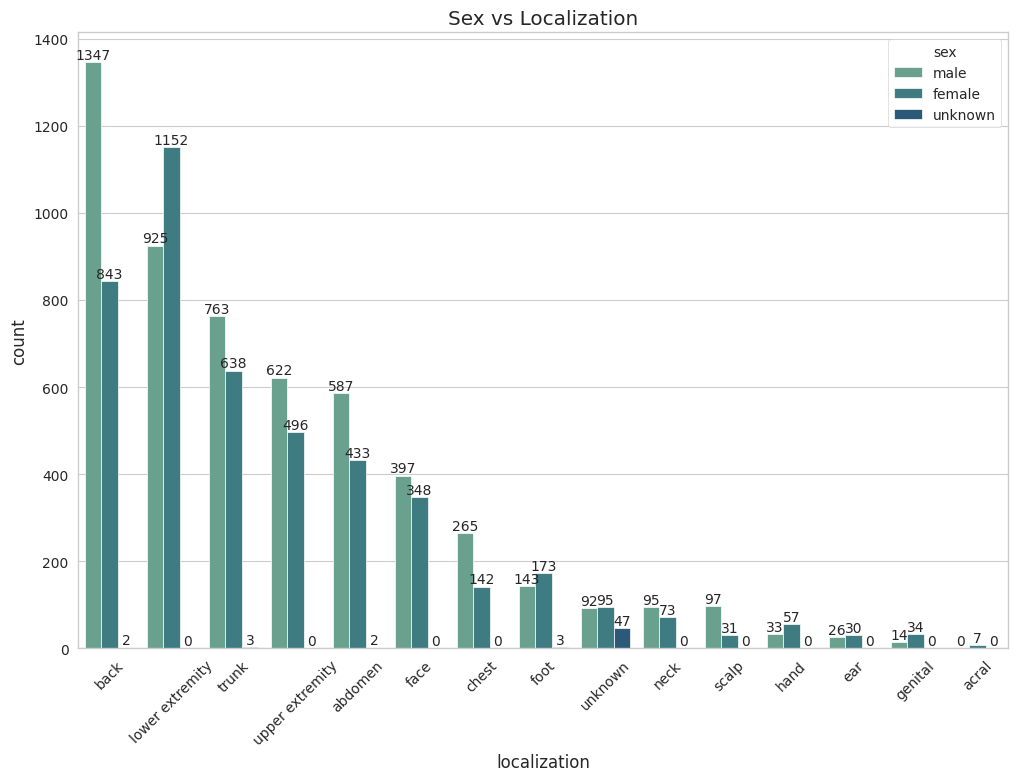

In [24]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12, 8))
ax = sns.countplot(x='localization',hue='sex', data=df_eda, order = df_eda['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Sex vs Localization')
plt.xticks(rotation=45)
plt.show()

#### Sex vs diagnosis verification type

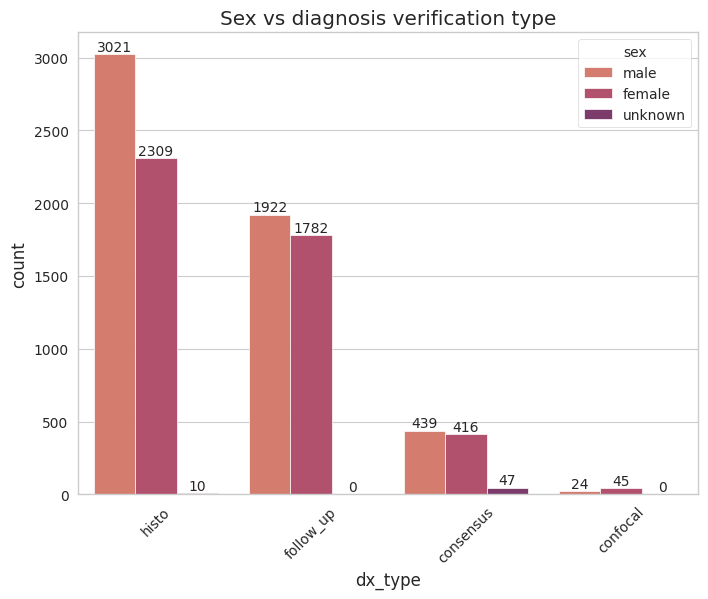

In [25]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='dx_type',hue='sex', data=df_eda, order = df_eda['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Sex vs diagnosis verification type')
plt.xticks(rotation=45)
plt.show()

#### Age vs Sex

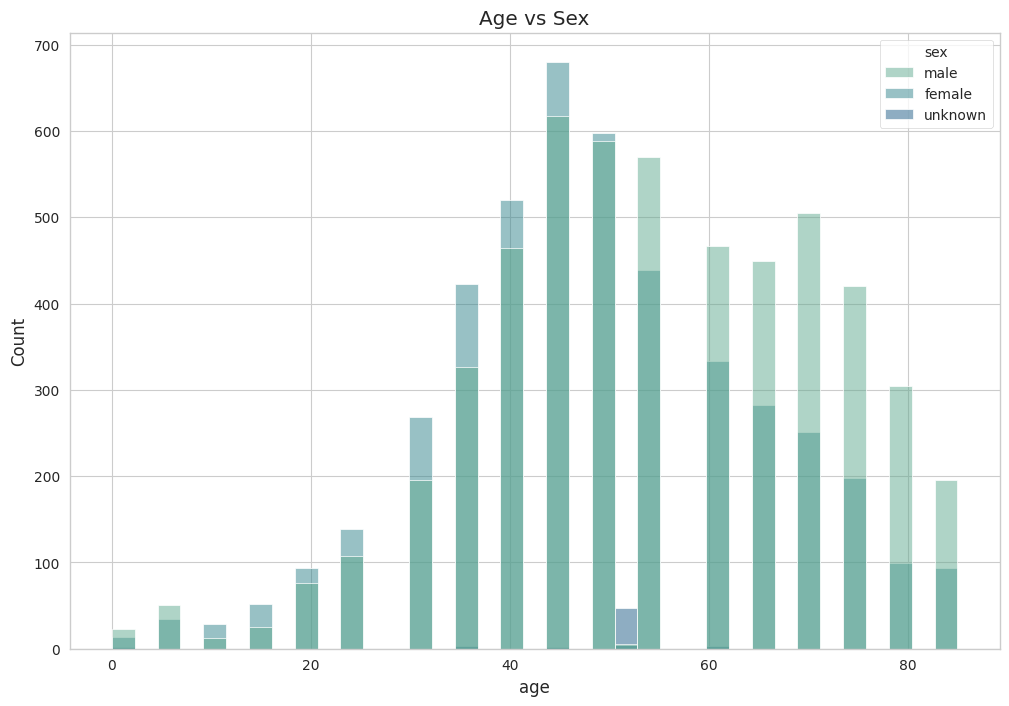

In [26]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
# ax = sns.histplot(data=df_eda, x='age',hue='sex',multiple='stack', palette = 'crest')
ax = sns.histplot(data=df_eda, x='age',hue='sex', palette = 'crest')
plt.title('Age vs Sex')
plt.show()

#### Age vs Localization Area

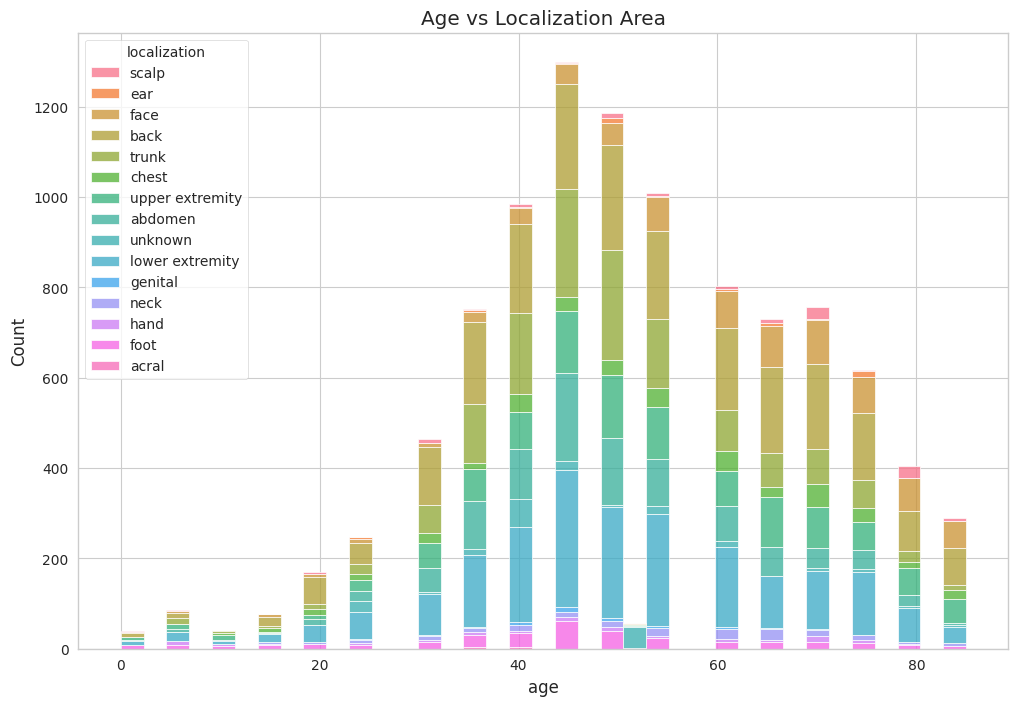

In [27]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df_eda, x='age',hue='localization',multiple='stack')
plt.title('Age vs Localization Area')
plt.show()

## Data modelling

In [10]:
base_dir = 'files'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

for label in class_labels:
    os.makedirs(os.path.join(train_dir, label))
    os.makedirs(os.path.join(val_dir, label))

### Create Train and Val Sets

In [11]:
# Create a val set using df because images might have augmented duplicates in the train set
y = df['dx']
_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)
df_val.shape

(938, 8)

In [12]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

### Create a train set that excludes images that are in the val set

In [13]:
# This set is df_data excluding all rows that are in the val set

# used to identify if an image is part of the train or val set
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identify train and val rows
# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)

# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']

print(len(df_train))
print(len(df_val))

9077
938


In [14]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [15]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

### Transfer the images into the folders

In [16]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [17]:
# Get a list of images in each of the two folders
# folder_1 = os.listdir('/content/raw/ham10000_images_part_1')
# folder_2 = os.listdir('/content/raw/ham10000_images_part_2')
folder_1 = os.listdir('../input/ham10000_images_part_1')
folder_2 = os.listdir('../input/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

In [18]:
# Transfer the train images
for image in train_list:
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        # src = os.path.join('/content/raw/ham10000_images_part_1', fname)
        src = os.path.join('../input/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        # src = os.path.join('/content/raw/ham10000_images_part_2', fname)
        src = os.path.join('../input/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [19]:
# Transfer the val images
for image in val_list:
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        # src = os.path.join('/content/raw/ham10000_images_part_1', fname)
        src = os.path.join('../input/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        # src = os.path.join('/content/raw/ham10000_images_part_2', fname)
        src = os.path.join('../input/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [20]:
# cnt of train images in each folder

for label in class_labels:
  print(len(os.listdir(f"files/train_dir/{label}")))

5954
1074
1024
484
301
131
109


In [21]:
# cnt of train images in each folder

for label in class_labels:
  print(len(os.listdir(f"files/val_dir/{label}")))

751
39
75
30
26
11
6


### Augment the train images in ```aug_dir```

In [22]:
# not augmenting class 'nv'
class_list = class_labels[1:]

for item in class_list:
    # Creating temporary directories only
    aug_dir = 'aug_dir' # base directory
    os.mkdir(aug_dir) # uncomment these
    # subdir within the base directory to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir) # uncomment these

    # Choose a class
    img_class = item

    # list all images in that directory
    # img_list = os.listdir('/content/files/train_dir/' + img_class)
    img_list = os.listdir('files/train_dir/' + img_class)

    # copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('files/train_dir/' + img_class, fname)
            # src = os.path.join('/content/files/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'files/train_dir/' + img_class
    # save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224,224),
                                              batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    num_aug_images_wanted = 6000 # total number of images we want to have in each class

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):
        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [23]:
# cnt of train images in each folder.
# this counts both original images and augmented images

for label in class_labels:
    # print(len(os.listdir(f'/content/files/train_dir/{label}')))
    print(len(os.listdir(f"files/train_dir/{label}")))

5954
5920
5920
5858
5217
5290
4410


In [24]:
# cnt of val images in each folder.
# this counts both original images and augmented images

for label in class_labels:
    # print(len(os.listdir(f'/content/files/val_dir/{label}')))
    print(len(os.listdir(f"files/val_dir/{label}")))

751
39
75
30
26
11
6
